```
Alexander Baquiax
12007988
```

In [114]:
import numpy as np
import pandas as pd
import cvxpy as cp
from numpy import linalg as LA
from IPython.display import display, Markdown
import matplotlib.pyplot as plt

In [115]:
data = pd.read_csv('data1.csv')
data = data.drop(data.columns[0], axis=1)
## show only first 4 elements
## data = data.iloc[:4]
data.head()

,Bonos,Acciones,Mercado Monetario
0,20.2553,262.935,100.00
1,25.6860,268.730,102.33
2,23.4297,284.090,105.33
3,28.7463,289.162,108.89
4,33.4484,299.894,113.08


### Tasas de rendimiento ($r$)

In [116]:
r = pd.DataFrame(columns=data.columns)

for i in range(1, len(data)):
        new_row = (data.iloc[i] - data.iloc[i-1]) / data.iloc[i-1]
        r = r.append(new_row, ignore_index=True)

r.head()

,Bonos,Acciones,Mercado Monetario
0,0.268113,0.022040,0.023300
1,-0.087842,0.057158,0.029317
2,0.226917,0.017853,0.033799
3,0.163572,0.037114,0.038479
4,0.123560,0.009340,0.043244


### Tasa de rendimiento promedio ($\overline{r}$)

In [117]:
r_promedio = pd.DataFrame(columns=r.columns)
r_promedio.loc[0] = r.mean()
r_promedio.head()

,Bonos,Acciones,Mercado Monetario
0,0.120571,0.078503,0.06323


### Valor esperado del rendimiento ($\mu$)

In [118]:
u = pd.DataFrame(columns=r.columns)

row = [0] * len(r.columns)

for i in range(len(r.columns)):
    product = 1
    for t in range(len(r)):
        product *= (1 + r.iloc[t][i])
    
    product = (product  ** (1/len(r))) - 1

    row[i] = product

u = u.append(pd.Series(row, index=data.columns), ignore_index=True)
u.head()


,Bonos,Acciones,Mercado Monetario
0,0.107321,0.073669,0.062701


### Varianza del rendimiento ($\sigma^2$)

In [119]:
var = pd.DataFrame(columns=r.columns)

row = [0] * len(r.columns)

for i in range(len(r.columns)):
    result = 0
    for j in range(len(r)):
        result += (r.iloc[j][i] - r_promedio.iloc[0][i]) ** 2

    result = result / (len(r) - 1)

    row[i] = result

var = var.append(pd.Series(row, index=data.columns), ignore_index=True)
var.head()

,Bonos,Acciones,Mercado Monetario
0,0.028443,0.011387,0.001181


### Covarianza ($\Sigma$)

In [120]:
cov = pd.DataFrame(columns=r.columns, index=range(len(r.columns)))
for i in range(0, len(r.columns)):
        for j in range(0, len(r.columns)):
                if i==j:
                        cov.iloc[i,j] = var.iloc[0][j]
                else:
                        sum = 0
                        for t in range(0, len(r)):
                                sum += (r.iloc[t][i] - r_promedio.iloc[0][i]) * (r.iloc[t][j] - r_promedio.iloc[0][j])
                        
                        cov.iloc[i,j]= sum / len(r)

cov.head()

,Bonos,Acciones,Mercado Monetario
0,0.028443,0.003866,0.000207
1,0.003866,0.011387,-0.000195
2,0.000207,-0.000195,0.001181


## Resolución del problema

$$ \min x^T\Sigma x$$
s.a
$$ \mu^Tx \geq R$$
$$ \sum_{i=0}^n x_i = 1$$
$$ x_i \geq 0, i=1,...,n$$

Sabemos que el problema dado es un problema `QP` con la forma (indicado en el problema):

$$ \frac{1}{2}x^TQx + c^Tx $$

Por lo tanto concluimos que $\Sigma = Q$ y $c = 0$

Verificamos si la matriz `Q` es `PD`, utilizando sus eignevalues:

In [121]:
display(Markdown(cov.to_markdown()))

|    |       Bonos |     Acciones |   Mercado Monetario |
|---:|------------:|-------------:|--------------------:|
|  0 | 0.0284435   |  0.00386593  |         0.000207034 |
|  1 | 0.00386593  |  0.0113868   |        -0.000195218 |
|  2 | 0.000207034 | -0.000195218 |         0.00118147  |

In [122]:
LA.eigvals(cov.to_numpy(dtype=float))

array([0.02927973, 0.01055737, 0.00117468])

Y podemos notar que todos son `> 0` por lo tanto podemos decir que es una `PD`. Así mismo, sabemos que una función `QP` es convexa, por lo tanto concluimos con que el problema es `fuertemente convexo`.

### Procedemos resolver el problem de minimización

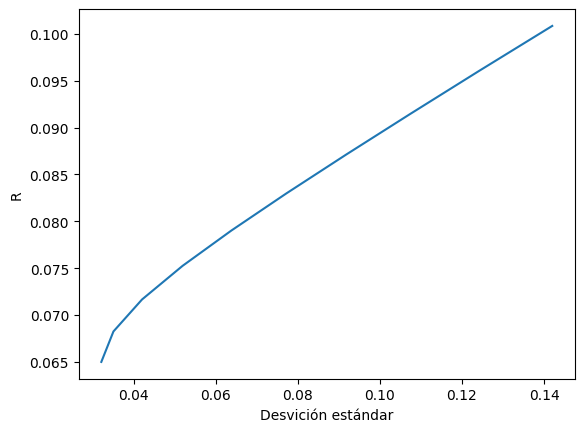

In [123]:
## Calculate and graph Markowitz’s Efficient Frontier (EF)
R_min=0.065
R_max=0.105

portfolio_std = []
portfolio_returns = []
portafolio_x = []

R=R_min

while R <= R_max:
    x = cp.Variable(len(cov.columns))
    
    objective = cp.Minimize(cp.quad_form(x, cov.to_numpy(dtype=float)))

    constraints = [
        u.to_numpy(dtype=float)[0] @ x >= R,
        cp.sum(x) == 1,
        x >= 0
    ]

    problem = cp.Problem(objective, constraints)
    problem.solve()

    portfolio_std.append(np.sqrt(problem.value))
    portfolio_returns.append(R)
    portafolio_x.append(x.value)

    R += (R * 0.05)


plt.plot(portfolio_std, portfolio_returns)
plt.xlabel('Desvición estándar')
plt.ylabel('R')
plt.show()

In [124]:
display(Markdown(pd.DataFrame(portafolio_x, columns=cov.columns).to_markdown()))

|    |     Bonos |   Acciones |   Mercado Monetario |
|---:|----------:|-----------:|--------------------:|
|  0 | 0.0264788 |   0.101865 |         0.871657    |
|  1 | 0.096182  |   0.114617 |         0.789201    |
|  2 | 0.16937   |   0.128007 |         0.702623    |
|  3 | 0.246218  |   0.142066 |         0.611716    |
|  4 | 0.326908  |   0.156828 |         0.516263    |
|  5 | 0.411633  |   0.172328 |         0.416038    |
|  6 | 0.500594  |   0.188604 |         0.310802    |
|  7 | 0.594003  |   0.205693 |         0.200304    |
|  8 | 0.692083  |   0.223636 |         0.084281    |
|  9 | 0.807301  |   0.192699 |        -2.39994e-23 |